<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Evoked_Timescales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 🧠 Compute Evoked Signals for each subject using NPI.model_ECt
# ============================================

# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 213 (delta 20), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (213/213), 29.03 MiB | 27.70 MiB/s, done.
Resolving deltas: 100% (61/61), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


# Example simulate single subject time series

In [2]:
# Single subject plots
sig_path = os.path.join(preproc_dir, f"{subjects[0]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subjects[0]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subjects[0]}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{subjects[0]}_MLP.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [ ]:
S=3 #number of steps
N=Z.shape[1] #number of regions
M=500 # initial times to consider

dur=30 #predicted activity
pert_strength=0.1

Zsim=np.zeros((N, dur+3, N))
for node in range(N):
  print(node)
  for ini in range(M):
    # Build a perturbation that only hits the last step and a single node: (S, N)
    perturbation = np.zeros((S, N), dtype=float)
    perturbation[-1, node] = pert_strength

    init_cond=np.reshape(X[ini,:],(S,N))

    Zsim[node,:,:] += NPI.model_time_series(model, init_cond + perturbation, tlen=dur, noise_strength=0.)
  Zsim[node,:,:]/=M

0
1


In [8]:
Zsim.shape

(450, 30, 450)

In [ ]:
# Empirical vs simulated time series, FC, and dFC

def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1)
    gz=stats.zscore(tseries)
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def dFC(tseries):
    return np.corrcoef(go_edge(tseries))

test_dur=3000 #int(len(Z)-len(Z)/100*80) #3000

emp=Z[-test_dur:,:]
sim=Zsim[-test_dur:,:]

FC_emp=np.corrcoef(emp.T)
FC_sim=np.corrcoef(sim.T)

dFC_emp=dFC(emp)
dFC_sim=dFC(sim)

In [ ]:
FC_emp.shape

(450, 450)

In [ ]:
dFC_emp.shape

(3000, 3000)

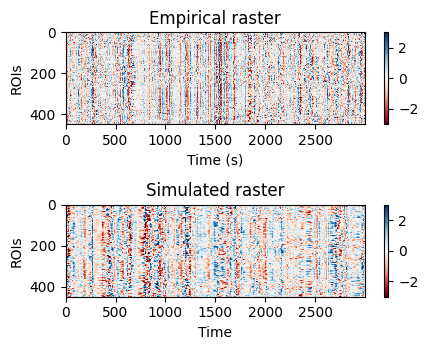

In [ ]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(stats.zscore(emp,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(stats.zscore(sim,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')
#plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# --- 8️⃣ Main EC(t) extraction loop ---
pert_strength = 0.1
ECts = {}

for sid in subjects:
    print(f"\n================ {sid} ================")

    sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
    inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
    tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
    mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

    if not os.path.exists(sig_path) or not os.path.exists(mdl_path):
        print(f"❌ Missing data or model for {sid}")
        continue

    # Load fMRI windows
    Z = np.load(sig_path)             # (T, N)
    X = np.load(inp_path)             # (M, S*N)
    Y = np.load(tgt_path)             # (M, N)

    # Load model
    model = load_model(mdl_path, X, Y)
    print("🧩 Model loaded.")

    # Compute EC(t)
    EC_t = NPI.model_ECt(model, input_X=X[:500,:], target_Y=Y[:500,:], pert_strength=pert_strength)
    ECts[sid] = EC_t
    print(f"✅ EC(t) computed: {EC_t.shape}")

    # Save
    out_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    np.save(out_path, EC_t)
    print(f"💾 Saved EC(t) → {out_path}")

    del Z, X, Y, model, EC_t
    gc.collect(); torch.cuda.empty_cache()

print("\n🎯 All subjects processed successfully.")





================ id_100206 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100206_ECt.npy

================ id_100307 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100307_ECt.npy

================ id_100408 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100408_ECt.npy

================ id_101006 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_101006_ECt.npy

================ id_101107 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/driv